### DAY 9

### Oil & Gas Data Research, Web Scraping and Analysis

### Business Problem
Are countries decoupling economic growth from oil consumption?

“Decoupling” here means: GDP grows while oil consumption stays flat or falls.

### DataSets I Need
1) Oil consumption (OWID)
2) GDP (World Bank)

In [1]:
import pandas as pd
import requests

In [18]:
# I want to load the oil comsumption data
df_oil = pd.read_csv("oil_consumption.csv")
df_oil.head()

,Entity,Code,Year,Oil consumption - TWh
0,Africa,NaN,1965,341.07257
1,Africa,NaN,1966,369.46457
2,Africa,NaN,1967,368.28156
3,Africa,NaN,1968,389.57162
4,Africa,NaN,1969,397.37260


I accessed GDP(Gross Domestic Product) data directly from the **World Bank using its public API**. 
The API URL was constructed with the specific indicator code for *Oil rents (% of GDP)* (`NY.GDP.MKTP.CD`) and configured to return the data in JSON format for all countries. Using the `requests` library, this URL allows me to programmatically retrieve the raw data instead of manually downloading it from the website. This ensures the data is official, up to date, and suitable for automated analysis.


In [21]:
# Load World Bank GDP via API
gdp_url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?format=json&per_page=20000"
r = requests.get(gdp_url)
r.status_code

200

To Convert the World Bank response into a table

In [23]:
gdp_json = r.json()
df_gdp = pd.json_normalize(gdp_json[1])
df_gdp.head()

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,AFE,2024,1.242694e+12,,,0,NY.GDP.MKTP.CD,GDP (current US$),ZH,Africa Eastern and Southern
1,AFE,2023,1.179359e+12,,,0,NY.GDP.MKTP.CD,GDP (current US$),ZH,Africa Eastern and Southern
2,AFE,2022,1.228968e+12,,,0,NY.GDP.MKTP.CD,GDP (current US$),ZH,Africa Eastern and Southern
3,AFE,2021,1.114145e+12,,,0,NY.GDP.MKTP.CD,GDP (current US$),ZH,Africa Eastern and Southern
4,AFE,2020,9.386076e+11,,,0,NY.GDP.MKTP.CD,GDP (current US$),ZH,Africa Eastern and Southern


Data Cleaning for the OWID oil consumption data
- Rename columns into clearer names
- Remove “regions” and “World”
- Keep only real countries using ISO3 codes

In [26]:
value_col = [c for c in df_oil.columns if c not in ["Entity", "Code", "Year"]][0]

df_oil= df_oil.rename(columns={"Entity": "country", "Year": "year", value_col: "oil_consumption_twh"})

exclude = ["World", "Asia", "Europe", "Africa", "European Union", "North America", "South America"]
df_oil = df_oil[~df_oil["country"].isin(exclude)]

df_oil["year"] = pd.to_numeric(df_oil["year"], errors="coerce")
df_oil["oil_consumption_twh"] = pd.to_numeric(df_oil["oil_consumption_twh"], errors="coerce")

# remove aggregates (World, regions) by keeping rows with a 3-letter country code
# (OWID country codes are usually 3 letters; regions often have blank codes or OWID_ codes)
df_oil = df_oil[df_oil["Code"].notna() & (df_oil["Code"].str.len() == 3)].copy()

df_oil

,country,Code,year,oil_consumption_twh
120,Algeria,DZA,1965,15.405252
121,Algeria,DZA,1966,20.272705
122,Algeria,DZA,1967,18.942032
123,Algeria,DZA,1968,20.167301
124,Algeria,DZA,1969,21.305931
...,...,...,...,...
6280,Vietnam,VNM,2020,307.297400
6281,Vietnam,VNM,2021,288.108760
6282,Vietnam,VNM,2022,337.139950
6283,Vietnam,VNM,2023,362.139620


Data Cleaning For the World Bank GDP data
- keep only countries
- rename columns

In [30]:
df_gdp_clean = df_gdp.rename(columns={
    "country.value": "country",
    "countryiso3code": "Code",
    "date": "year",
    "value": "gdp_usd"
})[["country", "Code", "year", "gdp_usd"]].copy()

df_gdp_clean["year"] = pd.to_numeric(df_gdp_clean["year"], errors="coerce")
df_gdp_clean["gdp_usd"] = pd.to_numeric(df_gdp_clean["gdp_usd"], errors="coerce")

df_gdp_clean.head()


,country,Code,year,gdp_usd
0,Africa Eastern and Southern,AFE,2024,1.242694e+12
1,Africa Eastern and Southern,AFE,2023,1.179359e+12
2,Africa Eastern and Southern,AFE,2022,1.228968e+12
3,Africa Eastern and Southern,AFE,2021,1.114145e+12
4,Africa Eastern and Southern,AFE,2020,9.386076e+11


In [32]:
url_countries = "https://api.worldbank.org/v2/country?format=json&per_page=400"
countries_json = requests.get(url_countries).json()

countries_df = pd.json_normalize(countries_json[1])

real_countries = countries_df[countries_df["region.value"] != "Aggregates"]["id"].tolist()

len(real_countries), real_countries[:10]

(217, ['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATG'])

In [33]:
df_gdp_clean = df_gdp_clean[df_gdp_clean["Code"].isin(real_countries)].copy()
df_gdp_clean.head()

,country,Code,year,gdp_usd
3185,Afghanistan,AFG,2024,NaN
3186,Afghanistan,AFG,2023,1.715223e+10
3187,Afghanistan,AFG,2022,1.449724e+10
3188,Afghanistan,AFG,2021,1.426000e+10
3189,Afghanistan,AFG,2020,1.995593e+10


Check for Missing Values

In [37]:
df_gdp_clean.isnull().sum()

country       0
Code          0
year          0
gdp_usd    2536
dtype: int64

I restricted the datasets to 2000–2024 so both datasets match the same time period.

In [40]:
START_YEAR = 2000
END_YEAR = 2024

df_oil = df_oil[(df_oil["year"] >= START_YEAR) & (df_oil["year"] <= END_YEAR)].copy()
df_gdp_clean = df_gdp_clean[(df_gdp_clean["year"] >= START_YEAR) & (df_gdp_clean["year"] <= END_YEAR)].copy()


Checked For missing values again

In [43]:
df_gdp_clean.isnull().sum()

country      0
Code         0
year         0
gdp_usd    192
dtype: int64

In [45]:
df_oil.isnull().sum()

country                0
Code                   0
year                   0
oil_consumption_twh    0
dtype: int64

I merged the two tables using:
- Code (country code)
- year
how="inner"
This will keep only rows where oil and GDP both exist for the same country-year.

In [55]:
df = pd.merge(
    df_oil,
    df_gdp_clean,
    on=["Code", "year"],
    how="inner"
)

df.head()


,country_x,Code,year,oil_consumption_twh,country_y,gdp_usd
0,Algeria,DZA,2000,103.132480,Algeria,5.479040e+10
1,Algeria,DZA,2001,106.775330,Algeria,5.941340e+10
2,Algeria,DZA,2002,118.397224,Algeria,6.151610e+10
3,Algeria,DZA,2003,123.174120,Algeria,7.348226e+10
4,Algeria,DZA,2004,128.746830,Algeria,9.191368e+10


Checked for Missing Values again

In [58]:
df[["oil_consumption_twh", "gdp_usd"]].isna().sum()


oil_consumption_twh    0
gdp_usd                0
dtype: int64

#### Fix the duplicate country columns

Why I had two “country” columns:
Because both datasets had a country column, and I merged using Code + year, not country name.

So pandas created:
- country_x (from OWID)
- country_y (from World Bank)
  
I will keep one and drop the other

In [61]:
df = df.rename(columns={"country_x": "country"})
df = df.drop(columns=["country_y"])

In [63]:
df

,country,Code,year,oil_consumption_twh,gdp_usd
0,Algeria,DZA,2000,103.132480,5.479040e+10
1,Algeria,DZA,2001,106.775330,5.941340e+10
2,Algeria,DZA,2002,118.397224,6.151610e+10
3,Algeria,DZA,2003,123.174120,7.348226e+10
4,Algeria,DZA,2004,128.746830,9.191368e+10
...,...,...,...,...,...
1945,Vietnam,VNM,2020,307.297400,3.466157e+11
1946,Vietnam,VNM,2021,288.108760,3.664748e+11
1947,Vietnam,VNM,2022,337.139950,4.134452e+11
1948,Vietnam,VNM,2023,362.139620,4.338577e+11


### Day 10

#### To Answer Business Question
Are countries decoupling economic growth from oil consumption?


#### Oil Intensity

How much oil does a country use to produce $1 billion GDP?

If intensity goes down over time → the country is producing more GDP with less oil → decoupling.

In [345]:
df["oil_intensity_twh_per_billion_usd"] = df["oil_consumption_twh"] / (df["gdp_usd"] / 1e9)

#### Growth rates (for decoupling classification)

For each country, I'll calculate:

- GDP growth % from last year to this year
- Oil consumption growth % from last year to this year

In [348]:
df = df.sort_values(["Code", "year"]).copy()
df["gdp_growth_%"] = df.groupby("Code")["gdp_usd"].pct_change() * 100
df["oil_growth_%"] = df.groupby("Code")["oil_consumption_twh"].pct_change() * 100

In [350]:
df

,country,Code,year,oil_consumption_twh,gdp_usd,oil_intensity_twh_per_billion_usd,gdp_growth_%,oil_growth_%
1800,United Arab Emirates,ARE,2000,229.33940,1.043374e+11,2.198056,NaN,NaN
1801,United Arab Emirates,ARE,2001,226.62102,1.033116e+11,2.193567,-0.983091,-1.185309
1802,United Arab Emirates,ARE,2002,235.30664,1.098162e+11,2.142732,6.296058,3.832663
1803,United Arab Emirates,ARE,2003,260.53530,1.243464e+11,2.095239,13.231341,10.721610
1804,United Arab Emirates,ARE,2004,281.55588,1.478244e+11,1.904665,18.881142,8.068227
...,...,...,...,...,...,...,...,...
1545,South Africa,ZAF,2020,274.01355,3.379747e+11,0.810752,-13.190705,-13.265124
1546,South Africa,ZAF,2021,288.23280,4.199863e+11,0.686291,24.265615,5.189251
1547,South Africa,ZAF,2022,287.79996,4.075960e+11,0.706091,-2.950154,-0.150170
1548,South Africa,ZAF,2023,290.03500,3.814407e+11,0.760367,-6.416971,0.776595


In [352]:
df.isnull().sum()

country                               0
Code                                  0
year                                  0
oil_consumption_twh                   0
gdp_usd                               0
oil_intensity_twh_per_billion_usd     0
gdp_growth_%                         78
oil_growth_%                         78
dtype: int64

Why There's 78 missing values:

Each country’s first year has no “previous year”, so growth is blank for the first row.

#### Build start vs end comparison

I created a pivot table so you can easily compare first year vs last year for each country.

This makes decoupling classification easy.

In [356]:
START_YEAR = df["year"].min()
END_YEAR = df["year"].max()

wide = df.pivot_table(
    index=["country", "Code"],
    columns="year",
    values=["gdp_usd", "oil_consumption_twh", "oil_intensity_twh_per_billion_usd"],
    aggfunc="first"
)

# Keep only countries with both endpoints available
wide = wide.dropna(subset=[
    ("gdp_usd", START_YEAR), ("gdp_usd", END_YEAR),
    ("oil_consumption_twh", START_YEAR), ("oil_consumption_twh", END_YEAR),
    ("oil_intensity_twh_per_billion_usd", START_YEAR), ("oil_intensity_twh_per_billion_usd", END_YEAR)
]).copy()

# Create a flat summary dataframe (one row per country)
summary = wide.reset_index()

summary["gdp_change_%"] = (summary[("gdp_usd", END_YEAR)] / summary[("gdp_usd", START_YEAR)] - 1) * 100
summary["oil_change_%"] = (summary[("oil_consumption_twh", END_YEAR)] / summary[("oil_consumption_twh", START_YEAR)] - 1) * 100
summary["intensity_change_%"] = (summary[("oil_intensity_twh_per_billion_usd", END_YEAR)] / summary[("oil_intensity_twh_per_billion_usd", START_YEAR)] - 1) * 100


#### Classify decoupling

In [359]:
import numpy as np

conditions = [
    (summary["gdp_change_%"] > 0) & (summary["oil_change_%"] < 0),
    (summary["gdp_change_%"] > 0) & (summary["oil_change_%"] > 0) & (summary["intensity_change_%"] < 0),
    (summary["gdp_change_%"] > 0) & (summary["oil_change_%"] > 0) & (summary["intensity_change_%"] >= 0),
]
choices = ["Absolute decoupling", "Relative decoupling", "No decoupling"]

summary["decoupling_type"] = np.select(conditions, choices, default="Other / GDP fell")

summary["decoupling_type"].value_counts()


decoupling_type
Relative decoupling    52
Absolute decoupling    25
Other / GDP fell        1
Name: count, dtype: int64

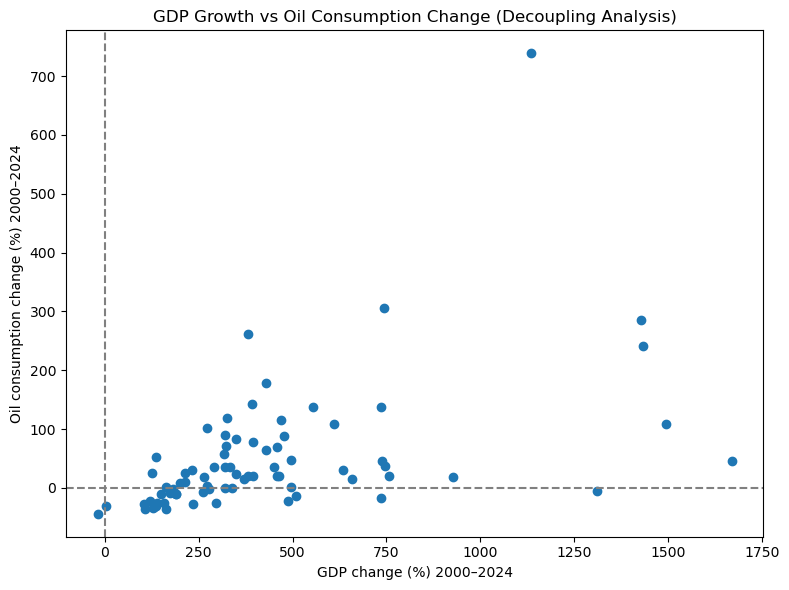

In [361]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(summary["gdp_change_%"], summary["oil_change_%"])

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")

plt.xlabel("GDP change (%) 2000–2024")
plt.ylabel("Oil consumption change (%) 2000–2024")
plt.title("GDP Growth vs Oil Consumption Change (Decoupling Analysis)")

plt.tight_layout()
plt.show()

The scatter plot compares how much each country’s economy grew (x-axis) against how much its oil consumption changed (y-axis) between 2000 and 2024. 

Most countries sit in the top-right quadrant, meaning GDP increased and oil consumption also increased. 
However, the fact that these countries were still classified as relative decoupling indicates that, for many of them, GDP grew faster than oil consumption, so oil intensity declined.

A sizeable group appears in the bottom-right quadrant (GDP up, oil down). These are the absolute decoupling countries—economies that expanded while reducing oil use, which is the clearest sign of structural decoupling. 

The chart also shows a few countries far to the right with very high GDP growth. Some of these also show large oil increases, suggesting that rapid economic expansion can still be accompanied by rising oil demand in certain contexts. Overall, the scatter confirms that economic growth does not automatically require proportional growth in oil consumption, but the pathway differs across countries.

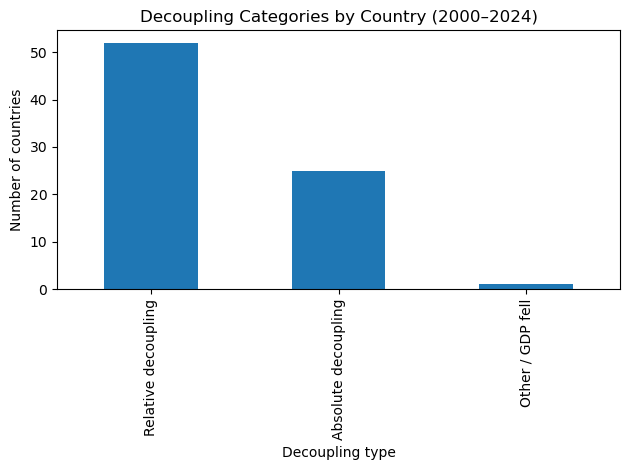

In [363]:
summary["decoupling_type"].value_counts().plot(kind="bar")
plt.title("Decoupling Categories by Country (2000–2024)")
plt.ylabel("Number of countries")
plt.xlabel("Decoupling type")
plt.tight_layout()
plt.show()

The bar chart summarizes how countries are distributed across decoupling categories. 

Out of 78 countries, relative decoupling dominates (52 countries), showing that the most common pattern is: GDP growth continues while oil consumption rises more slowly, resulting in a decline in oil intensity. 

A strong minority achieved absolute decoupling (25 countries), meaning GDP grew while oil consumption fell. 

Only one country falls into the “Other / GDP fell” category, indicating that most countries in the dataset experienced overall economic growth during the period.

This distribution supports the conclusion that decoupling is widespread, but in most cases it is still efficiency-led (relative) rather than driven by a full reduction in oil use (absolute). The presence of a substantial absolute decoupling group, however, shows that reductions in oil consumption alongside growth are achievable in practice.

In [365]:
summary.sort_values("intensity_change_%").head(10)[
    ["country","gdp_change_%","oil_change_%","intensity_change_%","decoupling_type"]
]

,country,gdp_change_%,oil_change_%,intensity_change_%,decoupling_type
year,,,,,
4,Azerbaijan,1309.468967,-4.948630,-93.256228,Absolute decoupling
70,Turkmenistan,1669.127929,46.453349,-91.721721,Relative decoupling
75,Uzbekistan,735.472379,-16.417231,-89.995747,Absolute decoupling
55,Romania,926.914943,18.124460,-88.497152,Relative decoupling
36,Kazakhstan,1493.485805,108.664572,-86.905150,Relative decoupling
71,Ukraine,489.160673,-22.361435,-86.822175,Absolute decoupling
9,Bulgaria,755.680500,20.566534,-85.909865,Relative decoupling
32,Ireland,507.895405,-14.021864,-85.856426,Absolute decoupling
20,Estonia,658.459773,14.572372,-84.894074,Relative decoupling


Top 10 largest reductions in oil intensity (best decouplers)

The table ranks countries by the greatest decline in oil intensity (oil consumption per $1B GDP), highlighting the strongest improvement in “economic output per unit of oil.” 

Countries at the top of this list achieved very large reductions in intensity (roughly 80–93% declines), meaning they now generate much more GDP for every unit of oil consumed compared to 2000.

The table also shows that strong intensity improvements can happen under both decoupling types. Some top performers fall under absolute decoupling (GDP up, oil down), indicating a genuine reduction in oil dependence. 

Others fall under relative decoupling (GDP up, oil also up), showing that even where oil demand increased, economies still became substantially more efficient because GDP expanded faster than oil consumption. Overall, the table provides clear “best performer” examples to spotlight in reporting and to use as benchmarks for countries seeking to reduce oil dependence while maintaining growth.

#### Recommendations
1) Policy / strategy 

Relative decouplers should focus on moving from relative → absolute by:

- expanding renewable power and electrification

- improving efficiency standards in transport/industry

- shifting from oil-based growth into services/technology/manufacturing upgrades

2) High oil-growth + high GDP-growth countries should manage transition risks by:

- planning for oil price volatility

- reducing oil dependence in government revenue and trade

3) Absolute decouplers can be used as “case studies”:

- investigate what changed (energy mix, regulation, industrial structure, efficiency programs).